In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import cartopy.crs as ccrs

In [2]:
SST_nc = xr.open_dataset("ERA5_SST.nc")
coarse_lat = np.array(SST_nc["latitude"][::10]) # 0.25 deg * 10 = 2.5 deg
coarse_lon = np.array(SST_nc["longitude"][::10])
time = pd.Series(SST_nc["valid_time"])
no_leapdays = ~((time.dt.month == 2) & (time.dt.day == 29))

In [3]:
land_sea_mask_nc = xr.open_dataset("lsm_1279l4_0.1x0.1.grb_v4_unpack.nc")
land_sea_mask = np.array(land_sea_mask_nc["lsm"].sel({"latitude": coarse_lat, "longitude": coarse_lon}, method="nearest")[0, ...])
land_sea_mask = np.where(land_sea_mask > 0, 1, 0).astype(bool)
land_sea_mask_flatten = land_sea_mask.flatten()

In [4]:
SST_data_arr = np.array(SST_nc["sst"].sel({"latitude": coarse_lat, "longitude": coarse_lon}))
SST_data_arr_no_leap = SST_data_arr[no_leapdays, ...].reshape(30,365,len(coarse_lat),len(coarse_lon))
# The SST array now has the shape of 30 years * 365 days * nlat * nlon
SST_clim = np.mean(SST_data_arr_no_leap, axis=0)
SST_anomaly = SST_data_arr_no_leap - SST_clim

cos_factor_root = np.cos(np.deg2rad(coarse_lat))**0.5
SST_anomaly_weighted = SST_anomaly * cos_factor_root[None,None,:,None]

SST_flatten = SST_anomaly_weighted.reshape(30*365, len(coarse_lat)*len(coarse_lon))
SST_valid = SST_flatten[:, ~land_sea_mask_flatten]

In [5]:
SST_PCA = PCA(n_components=3) # any number will be fine
SST_PCA.fit(SST_valid)

PCA(n_components=3)

In [6]:
PC1 = np.full(len(coarse_lat)*len(coarse_lon), np.nan)
PC1[~land_sea_mask_flatten] = SST_PCA.components_[0,:] # Fill PC1 at appropriate overwater entries
PC1_2D = PC1.reshape(len(coarse_lat), len(coarse_lon)) / cos_factor_root[:,None] # Invert the cosine factor

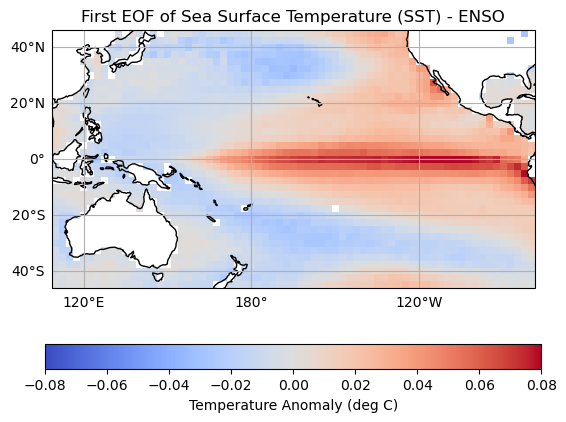

In [7]:
plt.figure()
plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180)) # the central_longitude option is needed to plot across the International Date Line
plt.pcolormesh(coarse_lon, coarse_lat, PC1_2D, cmap="coolwarm", vmin=-0.08, vmax=0.08, transform=ccrs.PlateCarree())
plt.gca().coastlines()
gl = plt.gca().gridlines(draw_labels=True)
gl.top_labels = False
plt.title("First EOF of Sea Surface Temperature (SST) - ENSO")
plt.colorbar(orientation="horizontal", label="Temperature Anomaly (deg C)")
plt.savefig("SST_EOF", dpi=300, bbox_inches="tight")